# Deep Learning Project Nicolas Lapautre
## 


We are going to solve a simple optimal growth model with one agent, a simplified version of [Brock and Mirman (1972)](https://assoeconomiepolitique.org/wp-content/uploads/Brock-et-Mirman-1972.pdf).  

The agent aims to maximize her time-separable life time utility subject to her budget constraint ( i.e the goal is to find the best consumption plan at each step $C_t$ that maximizes lifteime utility, subject to daily limits of how much we can consume):
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t} \ln\left(C_{t}\right)\\
\text{s.t.} \quad & K_{t+1} + C_{t} = Y_t + (1 - \delta) K_t
\end{align}
where $Y_t = K_{t} ^ \alpha$.

Here the second equation is called the budget constraint, where $C_t,K_t,Y_t$ are respectively consumption, saving, and income/production at time t. We assume that whatever is saved is used to produce income in the next period. We also choose an initial capital at time zero that the agent will start with($K_0$). Note: This is more of a macroeconomic model, so it's not modelling an individual person, but I am trying to explain it intuitively


Here we assume full depreciation, i.e. $\delta=1$, this allows the problem to have an analytical solution:

\begin{align}
K_{t+1} = \beta \alpha K_{t}^{\alpha}
\end{align}

We traditionally could numerically solve the above problem by using any global solution algorithm such as the value function iteration or policy iteration.  
Here we use a deep neural network to find the solution following [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575).  

### Expressing the problem Recursively


The above problem can be formulated recursively, this is true as long as the problem is convex or something.. Intuitively, since they live infinitely, and everyday they are faced with the same problem, you can reexpress the problem, as comparing the value that saving a certain amount gives me today, compared to tomorrow (similarly to reinforcement learning problems).

\begin{align}
V(K_t) &= \max_{K_{t+1}} [\ln\left(C_{t}\right)+\beta V(K_{t+1})]\\
\text{subject to: }C_t &= K_t^\alpha + (1 - \delta) K_t - K_{t+1}
\end{align}
Plugging in the budget constraint, substituting $C_t$ by the rhs of the equation above, we obtain:
\begin{align}
V(K_t) &= \max_{K_{t+1}} \ln\left(K_t^\alpha + (1 - \delta) K_t - K_{t+1}\right)+\beta V(K_{t+1}).
\end{align}
We notice that, $C_t$ disappears, and hence we are now optimizing in terms of $K_{t+1}$ (how much I'm saving for tomorrow) and not consumption anymore

Hence, $K_{t+1}=f(K_t)$ which is a function of $K_t$ f(K_t)$ denotes the **policy**, so $K_t$ is the state. 

One way to solve this is to find which function V satisfies this recursion. The traditional way to do this, is to find a grid of values k, and iterate V until it solves the problem. The issue with this is that if we have a high dimensional problem: $ K= [x,y,z]$ then we would have too many values to solve V for. This is where this neural network approximation is useful.

### How we find a loss


We are interested in approximating the policy $K_{t+1}=f(K_t) $ through a neural network. To do this we approximate $f(\cdot)$ with a neural network $\mathcal{N}(\cdot)$, such that $\mathcal{N}(K_t) \approx f(K_t) = K_{t+1} $.

To find the loss, we use the fact that the optimal solution will satisfy a few equation, just like how when a function is at it's maximal value, the equation $f'(x)=0$ is satisfed . Hence we can plug these optimality condition in the loss of the neural network. 




Taking the first order condition with respect to $K_{t+1}$, we obtain

\begin{align}
0 &= -\frac{1}{\underbrace{K_t^\alpha + (1 - \delta) K_t - K_{t+1}}_{=C_t}}+\beta \frac{d V(K_{t+1})}{d K_{t+1}}
\end{align}
Applying the [Envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem), we obtain
\begin{align}
\frac{d V(K_{t})}{d K_{t}} &= \frac{d}{d K_{t}}\ln\left(\underbrace{K_t^\alpha + (1 - \delta) K_t - K_{t+1}}_{=C_t}\right)\\
&= \frac{1}{C_t}\left(\frac{dK_t^\alpha}{dK_t} + (1 - \delta)\right)\\
&= \frac{1}{C_t}\left(\underbrace{\alpha K_{t}^{\alpha - 1}}_{=:r_t} + (1 - \delta)\right)\\
&= \frac{1}{C_t}\left(r_t + 1 - \delta\right).
\end{align}
Applying this result to replace $\frac{d V(K_{t+1})}{d K_{t+1}}$ in the first order condition, we obtain
\begin{align}
0 &= -\frac{1}{C_t} + \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)
\end{align}
where 
\begin{align}
r_{t+1} &= \alpha K_{t+1}^{\alpha - 1}\\
C_t &= K_t^\alpha + (1 - \delta) K_t - K_{t+1}\\
C_{t+1} &= K_{t+1}^\alpha + (1 - \delta) K_{t+1} - K_{t+2}.
\end{align}

This can be used as an error function, however in order to be able to interpret it as a minimization problem we reformulate it.
\begin{align}
0 &= -\frac{1}{C_t} + \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\\
\Leftrightarrow \frac{1}{C_t} &= \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right) \\
\Leftrightarrow C_t &= \frac{C_{t+1}}{\beta \left(1 - \delta + r_{t+1}\right)} \\
\Leftrightarrow 1 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)}  \\
\Leftrightarrow 0 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)} - 1.
\end{align}
Hence we know the equation above must be zero in optimum. Hence we will encode this equation as the **loss function** to train the neural network. 
I.e. we will train the neural network $\mathcal{N}(\cdot)$ such that the implied policy fullfills the equation above.  



### Problems with this technique I will attempt to solve



1. The above equilibrium function that is used in the loss can't be evaluated correctly if consumption or the level of capital are not positive. As negative consumption implies imaginary number of utility. Since a neural network is initialized randomly, this is not guaranteed by itself.

2. The author  addresses the above problem by approximating  the savings rate $s_t$ instead of $K_t+1$, such that $K_{t+1} = (1 - \delta) K_t + Y_t s_t =(1 - \delta) K_t +  Y_t \mathcal{N}(K_t)$. Since $Y_t$ is completely determined given the state $K_t$, this formulation still encodes the policy $K_{t+1}$, albeit more indirectly. They then use a sigmoid activaiton function such that they ensure that $s_t\in(0, 1)$ and hence $K_{t+1}\geq 0$ and $C_t\geq 0$. The problem with this is that, it is not reproducable for any models : in cases where we cannot simplify the problem to finding $s_t$ the technique of sigmoidal activation functions will not work. The author advises that in this case we could take measures such as (replacing negative numbers by small positive numbers and then adding a punishment term to the loss function), which help the neural network in the beginning of training. 

2. An important question is for what states we want the above equation to hold. In principle we want to hold it for all possible states $K_t$, but in practice we need to focus on a finite space. In this notebook we startout in the simplest possible way and sample capital from an exogenous interval $\mathcal{K}=[\underline{K}, \overline{K}]$, for which we know that $f(\mathcal{K})\in \mathcal{K}$. 

First, we need to import necessary python numerical libraries and tensorflow:

In [1]:
# Import necessary liblaries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

print("Version of tensorflow is {}".format(tf.__version__))

Version of tensorflow is 2.18.0


### For what values do we solve it 

We know that the solution takes the form of $K_{t+1} = \beta \alpha K_{t}^{\alpha}$ this is a contractive mapping ( $K_{t+1}<K_t$ for any value of K ), and has fixed point solution, $(\beta \alpha)^{1/(1-\alpha)} \approx 0.2$. I.E for any starting capital level, the consumer will end up with capital of 0.2. 

Knowing this, we are interested for what values we solve this. Originally in the notebook the authors only solve for K values between 0.1 and 1. Ideally we would want to be able to simulate any situation,such as where initial value of K is very high.  I started off doing it for the same rang of 0.1 to 1 as the author. However I noticed it did not generalize to any values. The approximations where weak for larger values. So i will try to figure out if it works for a wider range of values. Also check if my sigmoid works for greater values.

Below I show h



In [ ]:

# Define the recurrence relation
def recurrence_relation(x):
    return 0.99 * 0.36 * x**0.36

# Simulate the series
def simulate_series(x0, num_steps=100):
    x = np.zeros(num_steps)
    x[0] = x0
    for t in range(1, num_steps):
        x[t] = recurrence_relation(x[t-1])
    return x
# Initial values to test
initial_values = [0.01, 0.1, 1.0,2.0]

# Plot the series for each initial value
plt.figure(figsize=(10, 6))
for x0 in initial_values:
    x_series = simulate_series(x0)
    plt.plot(x_series, label=f'x0 = {x0}')

# Add fixed point line
plt.axhline(y=0.1, color='black', linestyle='--', label='Fixed Point (x* ≈ 0.2)')

# Add labels and legend
plt.xlabel('Time Step (t)')
plt.ylabel('x_t')
plt.title('Convergence of x_{t+1} = 0.99 * 0.36 * x_t^{0.36}')
plt.legend()
plt.grid()
plt.show()

We define the economic parameters, which are constant throughout and will be globals in this notebook.

In [7]:
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 1.0 # depreciation of capital
epsilon = 1e-7 #small value to avoid numerical errors

Since this model can be solved analytically for the full depreciation case, we implement the analytical solution (so that we can later check the solution found by the neural network).

#### Deep neural network 

In this section, we define the architecture of the deep neural net.  
Our goal is for the neural network to approximate the savings rate $s_t$, such that $K_{t+1} = Y_t s_t \approx Y_t \mathcal{N}\left(K_t \right)$.  
The neural network input is hence a 1-dimensional state $K_t$ and the output is the 1-dimensional savings rate $s_t$.


##### Hyper parameters

* Hyper parameter defines the architecture of the deep neural net. 

* Note that the purpose of this notebook is in the demonstration of the deep neural net. Detail analyses of the choice of hyper parameters are omitted and we use a densely connected feed forward neural network with two hidden layers as in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575). Since we are approximating the savings rate, we want our architecture to ensure that $s_t \in (0, 1)$. We can do this by using a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) in the output layer. This is in the spirit of encoding prior knowledge based on economics directly into the neural network architecture (relatedly, [Kahou et al. (2021)](https://www.nber.org/papers/w28981) and [Han et al. (2022)](https://arxiv.org/abs/2112.14377) show how symmetry can be encoded into the neural-network architecture and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market clearing neural network architectures.).  We assume the following structure of layers and activation functions: 
    * Layer 1: the input layer, 1 neuron corresponding to the capital stock $K_t$  
    * Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
    * Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
    * Layer 4: the output layer, 1 neuron corresponding to the savings rate $s_t$, such that $K_{t+1}=(1 - \delta) K_t + Y_t s_t$. We use a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6), ensuring that $s_t \in (0, 1)$.

In [5]:
# Layer setting
num_input = 1
num_hidden1 = 50
num_hidden2 = 50
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [1, 50, 50, 1]


### Activations to solve the problem of unfeasible predictions 

To avoid the problem of predicting values that would induce negative consumption I try to code in the activation that will only output values within the acceptable range. I started off with the relu output. However relu had the issue of dying relu. It outputed zero from intitialition. ( is this worse when relucostum then relu normal or ?).

Is costum sigmoid better then softplus or others? 

Is this better then coding it in the loss? can you otherwise put both together? 
is scaled sigmoid not as good? like if sigmoid can at least take all values, then wouldnt it be the same? 
how to implement it better, make it more parralelizable.

In [391]:

def truncated_relu(z, input_x):
    """
    Truncated ReLU activation function.

    Args:
        z: Input to the activation function (output of the previous layer).
        input_x: Original input to the neural network.
    
    Returns:
        Truncated ReLU output.
    """
    # remove negative values to small numerical to avoid imaginary number
    x_safe = tf.maximum(input_x, 0)

    # Calculate the upper bound to ensure positive consumption
    upper_bound = 6 #(1 - delta) * x_safe + K.pow(x_safe, alpha)
    
    # Apply standard ReLU to z
    relu_z = K.relu(z)
    
    # Truncate the ReLU output at the upper bound
    truncated_output = tf.where(relu_z < upper_bound, relu_z, upper_bound)
    
    return truncated_output

In [46]:

def scaled_sigmoid(x, input_x):
    """
    Scaled sigmoid activation function.
    
    Args:
        z: Input to the activation function (output of the previous layer).
        input_x: Original input to the neural network.
    
    Returns:
        Scaled sigmoid output.
    """
    
    x_safe = tf.maximum(input_x, 1e-8)
    
    # Calculate the upper bound to ensure positive consumption
    max_value = (1 - delta) * x_safe + tf.pow(x_safe, alpha)
    
    # Apply a sigmoid to x to get values in [0, 1]
    sigmoid_output = tf.sigmoid(x)
    
    return max_value * sigmoid_output


In [29]:

def scaled_sigmoid2(x, input_x):
    """
    Scaled sigmoid activation function.
    
    Args:
        z: Input to the activation function (output of the previous layer).
        input_x: Original input to the neural network.
    
    Returns:
        Scaled sigmoid output.
    """
    
    x_safe = tf.maximum(input_x,0)
    
    # Calculate the upper bound to ensure positive consumption
    max_value = (1 - delta) * x_safe + tf.pow(x_safe, alpha)
    
    
    return max_value * x

In [393]:
class TruncatedReLULayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TruncatedReLULayer, self).__init__(**kwargs)

    def call(self, inputs):
        """
        Apply the truncated ReLU activation.
        
        Args:
            inputs: A list containing [input_x, z].
                   - input_x: The original input to the neural network.
                   - z: The output of the previous layer.
        """
        input_x, z = inputs
        return truncated_relu(z, input_x)

In [47]:
class ScaledSigmoid(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledSigmoid, self).__init__(**kwargs)

    def call(self, inputs,):
        """
        Apply the scaled sigmoid activation.
        
        Args:
            inputs: A list containing [input_x, z].
                   - input_x: The original input to the neural network.
                   - z: The output of the previous layer.
        """
        input_x, z = inputs
        return scaled_sigmoid(z, input_x)

In [37]:
class ScaledSigmoid2(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledSigmoid2, self).__init__(**kwargs)

    def call(self, inputs,):
        """
        Apply the scaled sigmoid activation.
        
        Args:
            inputs: A list containing [input_x, z].
                   - input_x: The original input to the neural network.
                   - z: The output of the previous layer.
        """
        input_x, z = inputs
        return scaled_sigmoid2(z, input_x)

##### We define the neural network
We use [Keras](https://www.tensorflow.org/guide/keras) to define the neural network

In [48]:
from tensorflow.keras import Input, Model, initializers,layers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda



class NeuralNetwork:
    def __init__(self,costum_activ=False,sigmoid_activ=True,use_bn1=False,use_bn2=False, activation1='relu',activation2='relu',activation3='relu',initializer=keras.initializers.RandomNormal(mean=0.5,stddev=0.25)):
    # Define the input shape
        num_input = 1
        num_hidden1 = 50
        num_hidden2 = 50
        num_output = 1

        # Input layer
        input_layer = Input(shape=(num_input,))

        # Hidden layers
        hidden1 = Dense(num_hidden1, kernel_initializer=initializer)(input_layer)

        if use_bn1:
            hidden1 = tf.keras.layers.BatchNormalization()(hidden1)
        hidden1 = tf.keras.layers.Activation(activation1)(hidden1)

        hidden2 = Dense(num_hidden2, activation=activation2,kernel_initializer=initializer)(hidden1)

        if use_bn2:
            hidden2 = tf.keras.layers.BatchNormalization()(hidden2)

        if costum_activ:
            raw_output = Dense(num_output,kernel_initializer=initializer)(hidden2)
            if sigmoid_activ:
                final_output = ScaledSigmoid()([input_layer, raw_output])
            else:
                final_output = TruncatedReLULayer()([input_layer, raw_output])
        else:
            raw_output = Dense(num_output,activation=activation3,kernel_initializer=initializer)(hidden2)
            #final_output=Dense(num_output,activation=activation3,kernel_initializer=initializer)(hidden2)      
            final_output=ScaledSigmoid2()([input_layer, raw_output])
        self.model = Model(inputs=input_layer, outputs=final_output)

        self.optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

    def __call__(self, x):
        return self.model(x)
    
    def get_training_data(self,k_lb, k_ub, n_data):

        return tf.random.uniform(shape=[n_data, 1],minval=k_lb,maxval=k_ub,dtype=tf.dtypes.float32)
    
    
    def get_training_data2(self, k_lb, k_ub, n_data):
    
        start = np.random.uniform(k_lb, k_lb+5)
        end=np.random.uniform(k_ub-5,k_ub)
    
        X = np.linspace(start, end, n_data)

        np.random.shuffle(X)
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        X = tf.reshape(X, [n_data, 1])
        return X

    def compute_loss(self,X):
        """ 
        Compute the mean squared error in the equilibrium conditions.
        """
        # read out the state (this is trivial here because the state-space is one dimensional)
        K_t = X
        
        # compute output today
        Y_t = K_t ** alpha

        # use the neural network to predict the capital
        K_next= self.model(X)


        C_t= (1. - delta) * K_t + Y_t - K_next
        
        # predict capital in two periods
        K_2next= self.model(K_next)

        C_next= (1. - delta) * K_next + K_next**alpha - K_2next

        R_tplus1 = alpha * K_next ** (alpha - 1.)

        errREE = 1 - C_next / (beta * (C_t ) * (R_tplus1 + 1. - delta)+ epsilon) #+ epsilon**(-1)*tf.maximum(-C_next,0)+10**(-5)*tf.maximum(-K_next,0)

        loss = tf.reduce_mean(errREE ** 2)

        return loss
    
    def train(self, num_episodes=2001, batch_size=64, k_lb=0.10, k_ub=1.0, data_generator= None):
        """
        Train the model using generated data.
        
        Args:
            num_episodes: Number of training episodes.
            n_data_per_epi: Number of data points to generate per episode.
            k_lb: Lower bound for the training data.
            k_ub: Upper bound for the training data.
        """
        if data_generator is None:
            data_generator = self.get_training_data 
        train_loss = []

        for ep in range(num_episodes):
            # Generate training data
            X = data_generator(k_lb, k_ub, batch_size)

            # Compute the cost and gradients
            with tf.GradientTape() as tape:
                loss=self.compute_loss(X)
            gradients = tape.gradient(loss, self.model.trainable_variables)

            # Update the model's weights
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

            # Record the loss
            train_loss.append(loss.numpy())

            # Print progress
            if ep % 50 == 0:
                print(f"Episode {ep}, Loss: {loss.numpy()}")
            if ep % 200 ==0: 
                Y = self.get_training_data(k_lb, k_ub, batch_size)
                K_test=self.model(Y)
                Ktplus1 = self.model(X)

                plt.title("loss function")
                plt.plot(np.log10(np.array(train_loss)))
                plt.xlabel("Training Episode")
                plt.ylabel("loss [log10]")
                plt.show()
                plt.close()

                

                plt.title("policy")
                plt.xlabel("K")
                plt.ylabel("Knext")
                plt.scatter(X[:, 0], X[:, 0], label = "diagonal")
                plt.scatter(X[:, 0], Ktplus1[:, 0], s=100, label = "Knext")
                plt.scatter(X[:, 0], beta * alpha * X[:, 0] ** alpha, label = "Knext analytic (delta = 1)")
                plt.legend()
                plt.show()
                plt.close()

                # plt.title("policy")
                # plt.xlabel("K")
                # plt.ylabel("Knext")
                # plt.scatter(Y[:, 0], K_test[:, 0], s=100, label = "Ktestnext")
                # plt.scatter(Y[:, 0], beta * alpha * Y[:, 0] ** alpha, label = "Knext test analytic (delta = 1)")
                # plt.legend()
                # plt.show()
                # plt.close()

        return train_loss
    def print_model_summary(self):
        self.model.summary()
    def print_weights(self):
        # Print weights for each layer in the model
        for layer in self.model.layers:
            if hasattr(layer, 'get_weights') and layer.get_weights():  # Ensure the layer has weights
                weights = layer.get_weights()
                print(f"Layer: {layer.name}")
                print(f"Weights: {weights[0]}")
                if len(weights) > 1:  # If biases exist, print them
                    print(f"Biases: {weights[1]}")
                print()
            else:
                print(f"Layer: {layer.name} has no weights.")


In [20]:
fail=0
num_trial=10
for ep in range(num_trial):
    nn = NeuralNetwork(costum_activ=False,sigmoid_activ=False,use_bn1=False,use_bn2=False,activation1='relu',activation2='sigmoid',activation3='softplus',initializer=keras.initializers.GlorotNormal)
    if np.all(nn(tf.constant([0.1,0.5,1.,2.,3.,4.,5.,10.,100.])))==0:
        fail+=1
print(fail/num_trial)


0.0


In [53]:
nn = NeuralNetwork(costum_activ=True,sigmoid_activ=True,use_bn1=False,use_bn2=False,activation1='relu',activation2='relu',activation3='sigmoid',initializer=keras.initializers.GlorotNormal)


Episode 0, Loss: 0.18102562427520752


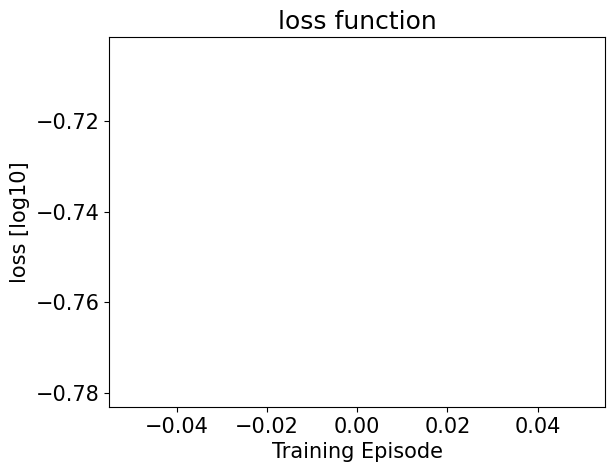

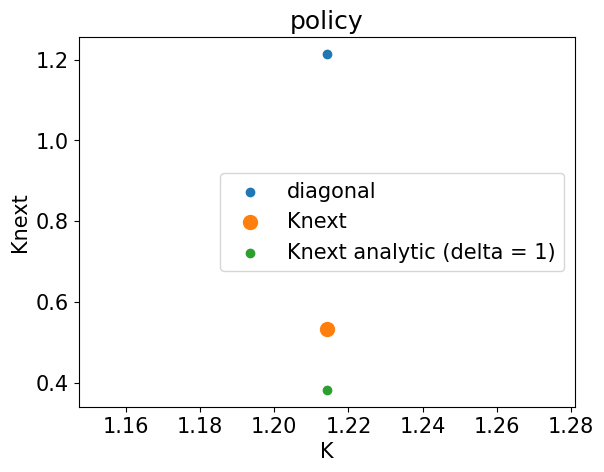

In [52]:
train_loss = nn.train(num_episodes=1, batch_size=1, k_lb=0.10, k_ub=1.0,data_generator=nn.get_training_data2)

In [1027]:
#next to do compare averages, variance. with batchnorm?  potententially like generalizaiton, and also check for why between 0 and 1.
#can also use the random integers thing between setss. but maybe useless. also can check testing error. 
#also do we want to code tabular? and check for time? 
#other idea is skip connection
#try for less restricted values of k see if it still works

tf.Tensor([[-1.61929]], shape=(1, 1), dtype=float32)


Episode 0, Loss: 0.913153886795044


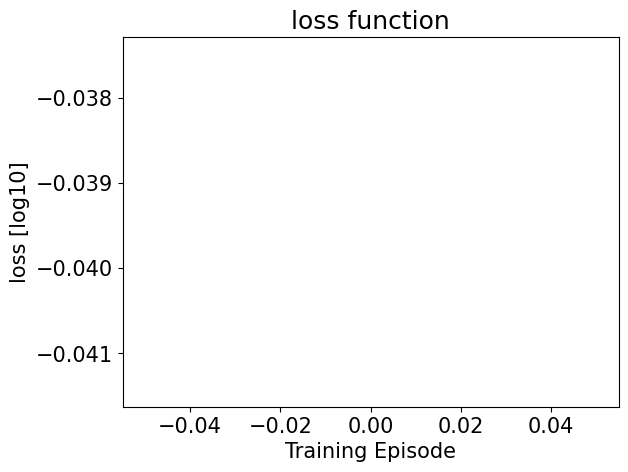

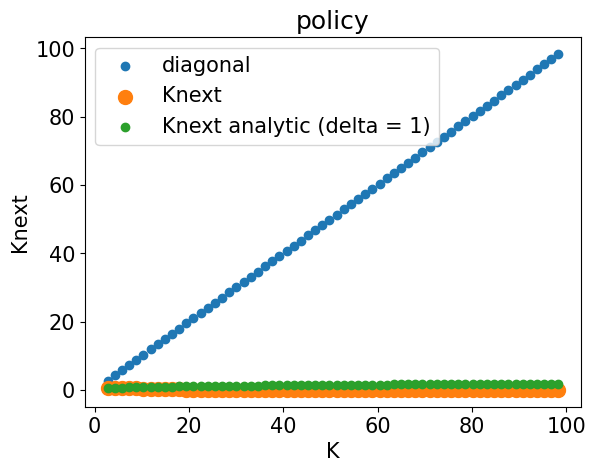

Episode 50, Loss: 0.04221281409263611
Episode 100, Loss: 0.022159624844789505
Episode 150, Loss: 0.011222897097468376
Episode 200, Loss: 0.005250136833637953


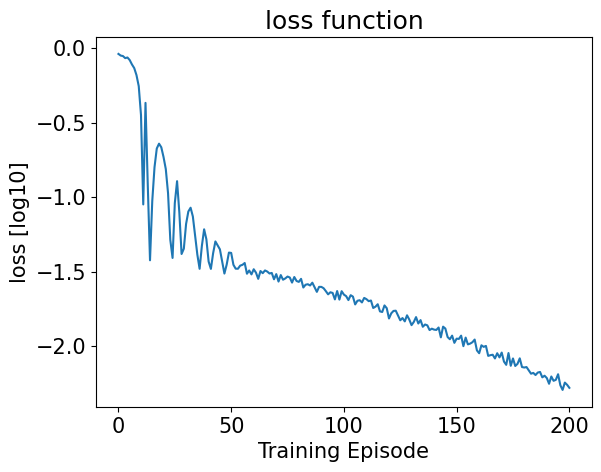

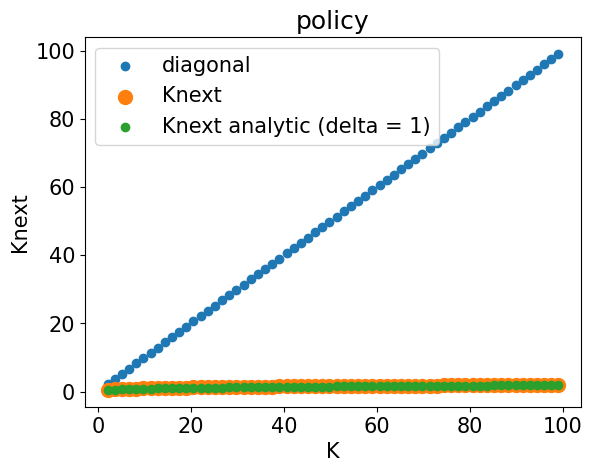

Episode 250, Loss: 0.0020090313628315926
Episode 300, Loss: 0.0005775574245490134
Episode 350, Loss: 0.000270409625954926


KeyboardInterrupt: 

In [54]:
train_loss = nn.train(num_episodes=501, batch_size=64, k_lb=0.10, k_ub=100,data_generator=nn.get_training_data2)

In [ ]:
nn.print_weights()

In [396]:
def compare_methods(num_trials=10, epochs=500):

    relu_losses = []
    costum_relu_losses = []

    for _ in range(num_trials):
        
        nn_relu = NeuralNetwork(costum_activ=False,sigmoid_activ=False,use_bn1=False,use_bn2=False, activation1='relu', activation2= 'relu', activation3= 'sigmoid', initializer= keras.initializers.GlorotNormal)
        relu_loss = nn_relu.train(num_episodes=epochs, batch_size=25, k_lb=0.10, k_ub=1.0)
        relu_losses.append(relu_loss)

        # Train with ReLU 
        nn_costum_relu = NeuralNetwork(costum_activ=True,sigmoid_activ=True,use_bn1=False,use_bn2=False, activation1='relu', activation2= 'relu', activation3= 'relu', initializer= keras.initializers.GlorotNormal)
        costum_relu_loss = nn_costum_relu.train(num_episodes=epochs, batch_size=25, k_lb=0.10, k_ub=1.0)
        costum_relu_losses.append(costum_relu_loss)

    # Compute mean loss
    relu_mean = np.mean(relu_losses, axis=0)
    print(costum_relu_losses)
    print(relu_losses)
    relu_std=np.std(relu_losses,axis=0)
    c_relu_mean = np.mean(costum_relu_losses, axis=0)
    c_relu_std=np.std(costum_relu_losses,axis=0)

    # Plot results
    plt.plot(relu_mean, label="ReLU ")
    plt.plot(c_relu_mean, label="Costum ReLU", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Effect of costum activations")
    plt.show()

Episode 0, Loss: 2383.089111328125


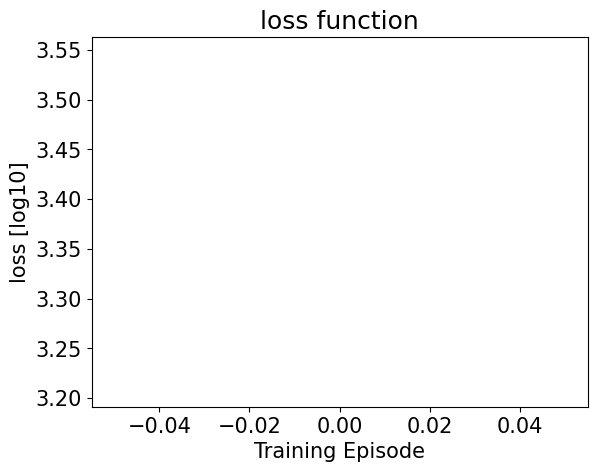

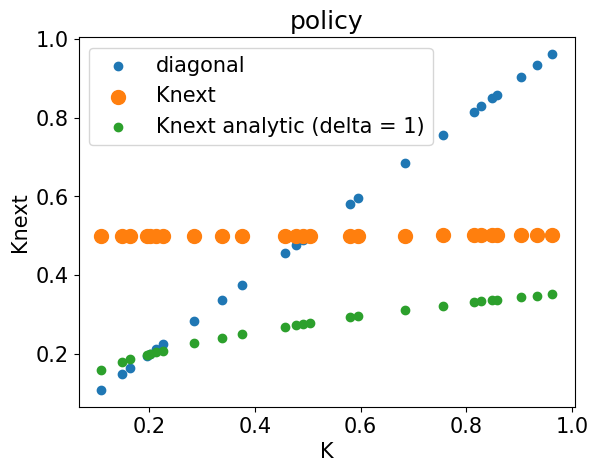

Episode 50, Loss: 18.00479507446289
Episode 0, Loss: 0.06469698250293732


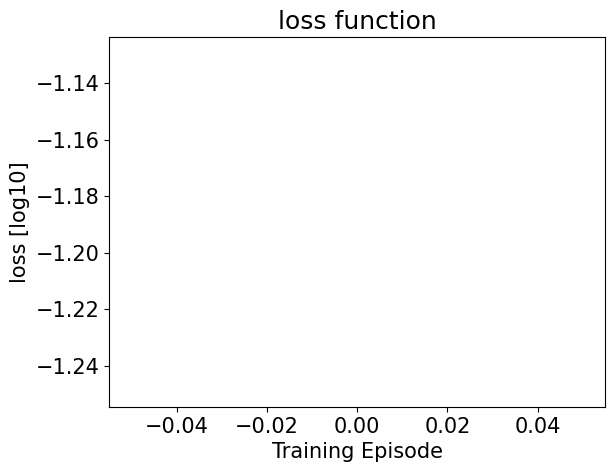

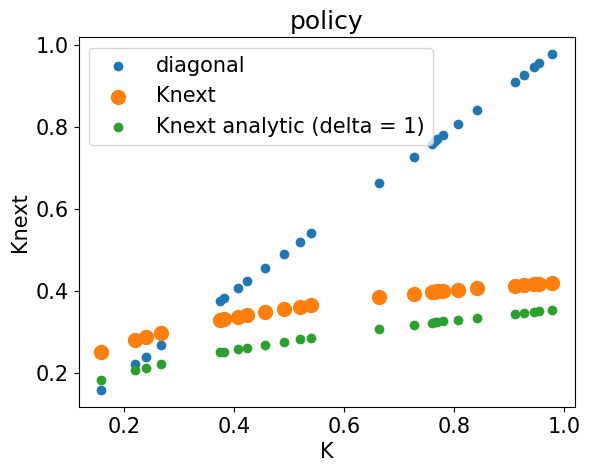

Episode 50, Loss: 0.01923287846148014
Episode 0, Loss: 3.6491053104400635


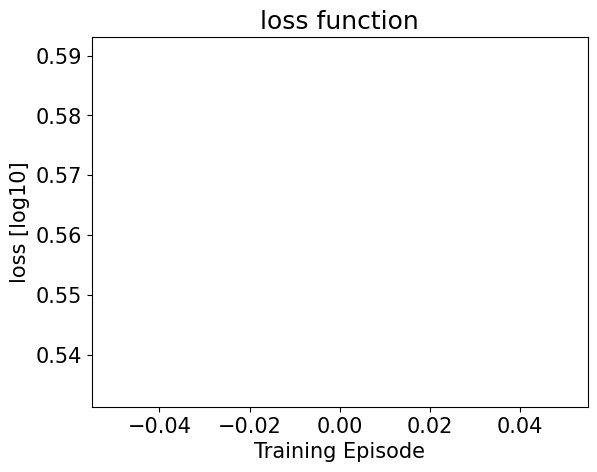

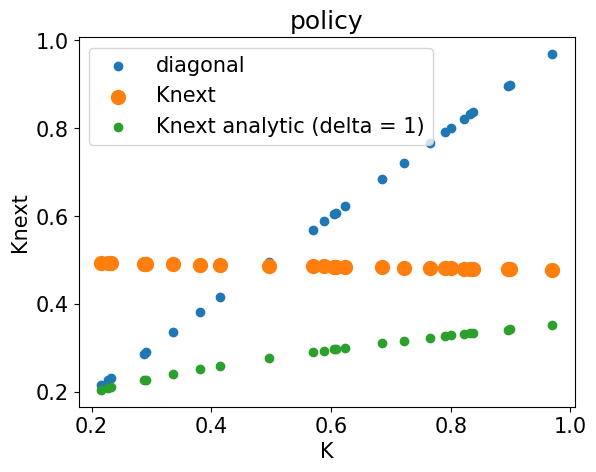

Episode 50, Loss: 384.1270446777344
Episode 0, Loss: 0.1588248759508133


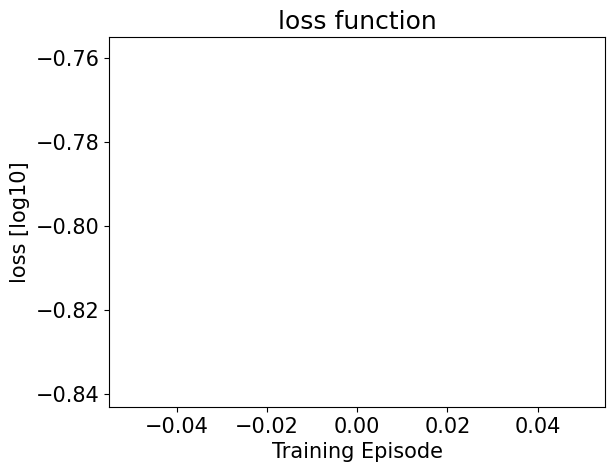

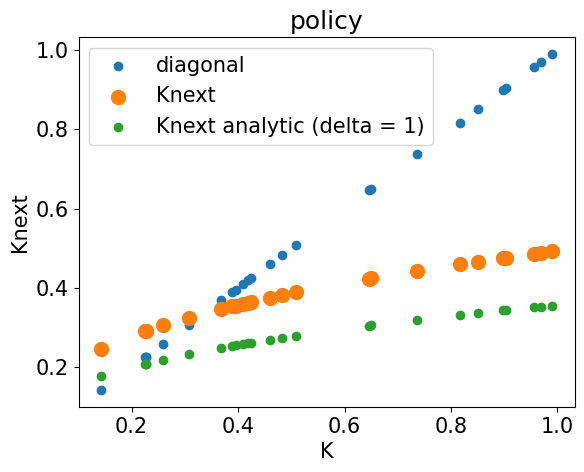

Episode 50, Loss: 0.014544590376317501
[[np.float32(0.06469698), np.float32(0.08278951), np.float32(0.061278418), np.float32(0.048296377), np.float32(0.0482524), np.float32(0.035162047), np.float32(0.04007828), np.float32(0.03478457), np.float32(0.03405246), np.float32(0.026477378), np.float32(0.03283713), np.float32(0.018742597), np.float32(0.02313973), np.float32(0.018287165), np.float32(0.024003213), np.float32(0.026464531), np.float32(0.022013133), np.float32(0.03664528), np.float32(0.027222566), np.float32(0.018957654), np.float32(0.024866896), np.float32(0.031891093), np.float32(0.027326178), np.float32(0.014130821), np.float32(0.029264705), np.float32(0.02328924), np.float32(0.027056776), np.float32(0.017476974), np.float32(0.017015416), np.float32(0.027214307), np.float32(0.023970127), np.float32(0.027615732), np.float32(0.021687124), np.float32(0.015754534), np.float32(0.02519237), np.float32(0.021313896), np.float32(0.015281405), np.float32(0.019585855), np.float32(0.01411254

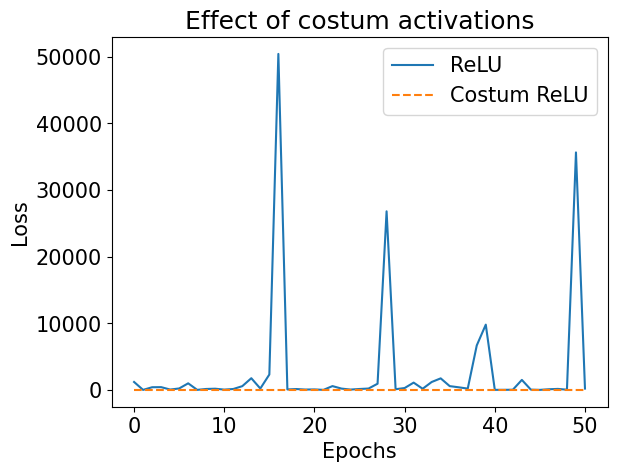

In [397]:
compare_methods(num_trials=2, epochs=51)

In [ ]:
batch_nn = BatchNormNN()
train_loss = batch_nn.train(num_episodes=2001, batch_size=64, k_lb=0.10, k_ub=1.0)

##### The batch dimension
Since neural networks are highly parallelizable, we typically do not want to evaluate the neural network for only a single state $K \in \mathbb{R}$, but for a vector of $N_{data}$ different capital levels $\mathbf{K} \in \mathbb{R}^{N_{data}\times 1}$. The output of the neural network is then a vector $\mathbf{s}\in \mathbb{R}^{N_{data}\times 1}$.  
The convention in deep learning is to have the different data samples on the 0-axis.

In [151]:
# test it
K_test = np.array([[1.], [2.]])

print("K_test = ", K_test)
print("nn prediction = ", nn(K_test))

K_test =  [[1.]
 [2.]]
nn prediction =  tf.Tensor(
[[0.02382197]
 [0.04764394]], shape=(2, 1), dtype=float32)


#### Implementing the cost function
As outlined above, we want to implement a cost-function which takes a vector of states $\mathbb{X}\in \mathbb{R}^{N_{data}\times 1}$ and a neural network $\mathcal{N}(\cdot)$, and then returns a vector of errors in the equilibrium conditions implied by the policy, which is encoded by the neural network.  
As explained above, the equilibrium condition is given by
\begin{align}
0 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)} - 1.
\end{align}
We use the [tf.function decorator](https://www.tensorflow.org/guide/function), which speeds up the evaluation of the cost function.

In [152]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state (this is trivial here because the state-space is one dimensional)
    K_t = X
    
    # compute output today
    Y_t = K_t ** alpha

    # use the neural network to predict the capital
    K_next= nn(X)


    C_t= (1. - delta) * K_t + Y_t - K_next
    
    # predict capital in two periods
    K_2next= nn(K_next)

    C_next= (1. - delta) * K_next + K_next**alpha - K_2next

    R_tplus1 = alpha * K_next ** (alpha - 1.)

    errREE = 1 - C_next / (beta * C_t * (R_tplus1 + 1. - delta))

    cost = tf.reduce_mean(errREE ** 2)
    
    
    
    # # get the implied capital in the next period
    # K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # C_t = Y_t - Y_t * s_t
    
    # # get the state in t + 1
    # X_next = K_tplus1
     
    # # get output in the next period
    # Y_tplus1 = K_tplus1 ** alpha
    
    # # predict the savings policy in the next period
    # s_tplus1 = nn(X_next)
    
    # # predict capital in the next period
    # C_tplus1 = Y_tplus1 - s_tplus1 * Y_tplus1
    
    # # compute the return on capital in the next period
    # R_tplus1 = alpha * K_tplus1 ** (alpha - 1.)
    
    # # Define the relative Euler error
    # errREE = 1 - C_tplus1 / (beta * C_t * (R_tplus1 + 1. - delta))
    
    # # compute the cost, i.e. the mean square error in the equilibrium conditions
    # cost = tf.reduce_mean(errREE ** 2)

    return cost, errREE, C_t, C_next, K_next, R_tplus1

In [156]:
# let's try
X = tf.constant([[1.], [2.], [3.]])

print("cost = ", compute_cost(X, nn)[0])

cost =  tf.Tensor(0.80051, shape=(), dtype=float32)


#### Gradients
Now we define a function that, for given data X, computes the gradient of the loss w.r.t. the neural network parameters.  
This gradient will be used to update the neural network parameters into the direction which decreases the loss function.

In [157]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [158]:
X = tf.constant([[1.], [2.], [3.]])

loss, grads = grad(X, nn)

print("loss = ", loss)
print("grads = ", grads)

AttributeError: 'NeuralNetwork' object has no attribute 'trainable_variables'

#### Optimizer
We now define an optimizer, essentially an improved version of SGD

In [87]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

## Sampling data
we make a function to generate training data.
Here we just sample exogenously from an interval.

In [160]:
def get_training_data(k_lb, k_ub, n_data):
    X = tf.random.uniform(
    shape = [n_data, 1],
    minval=k_lb,
    maxval=k_ub,
    dtype=tf.dtypes.float32)
    return X

## Training
We iteratively generate training data and update the neural network

#=================================================================
episode = 0, loss [log10] = 3.7685468196868896


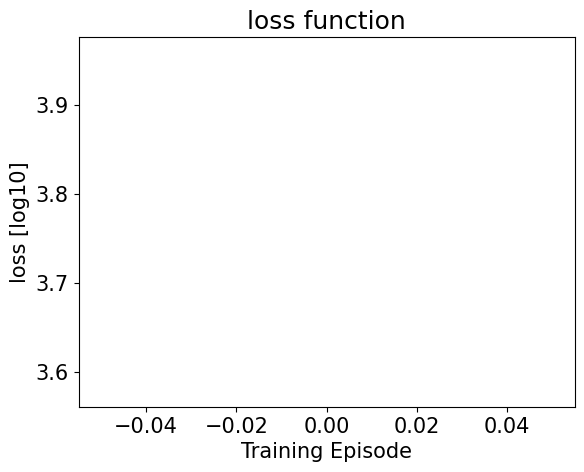

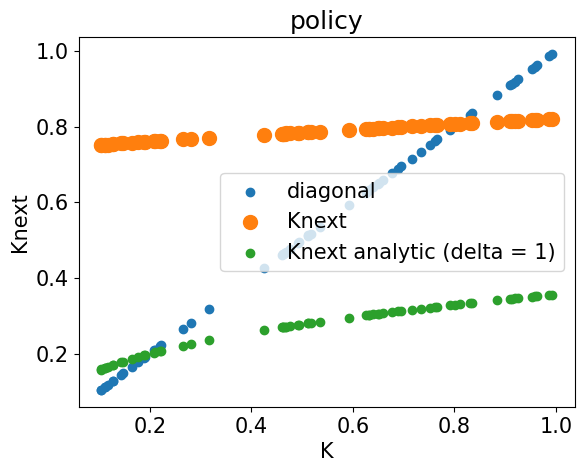

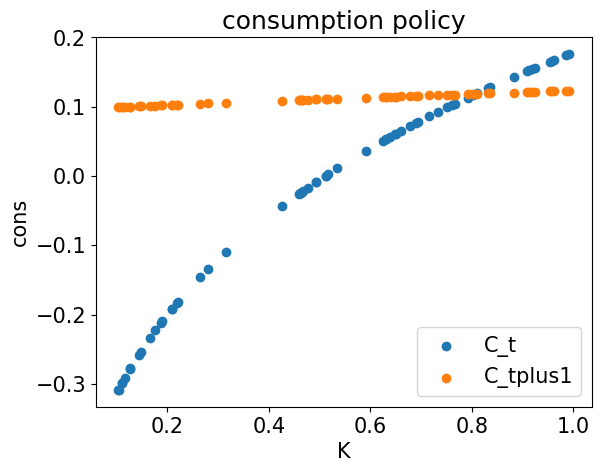

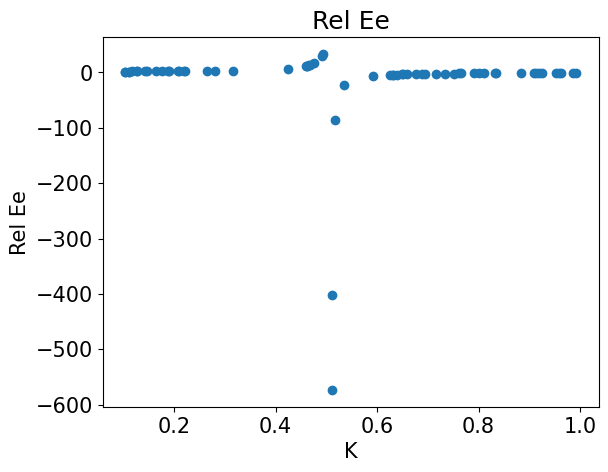

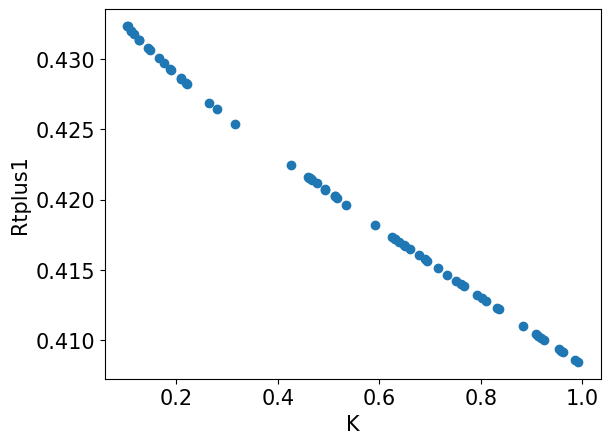

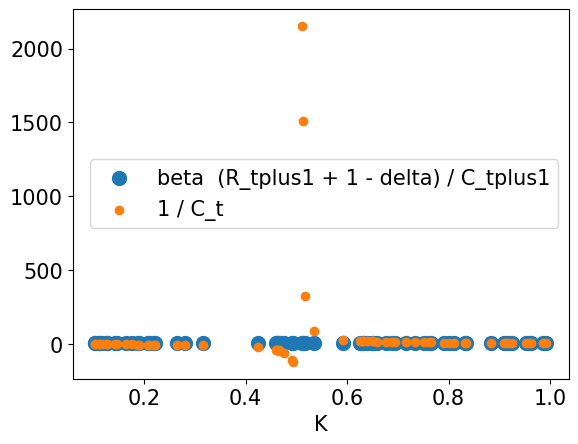

#=================================================================
episode = 100, loss [log10] = 2.8065848350524902
#=================================================================
episode = 200, loss [log10] = 1.94688880443573
#=================================================================
episode = 300, loss [log10] = 3.6579511165618896


KeyboardInterrupt: 

In [90]:
# Keep results for plotting
train_loss = []

num_episodes = 2001
n_data_per_epi = 64
k_lb = 0.10
k_ub = 1.0


for ep in range(num_episodes):
    # generate training data
    #generate 64 new random data points? 
    X = get_training_data(k_lb, k_ub, n_data_per_epi)

    # compute loss and gradients
    loss, grads = grad(X, nn)
    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % 100 == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % 500 == 0:
        cost, errREE, C_t, C_next, K_next, R_tplus1 = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], X[:, 0], label = "diagonal")
        plt.scatter(X[:, 0], K_next[:, 0], s=100, label = "Knext")
        plt.scatter(X[:, 0], beta * alpha * X[:, 0] ** alpha, label = "Knext analytic (delta = 1)")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.scatter(X[:, 0], C_next[:, 0], label="C_tplus1")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
       
        plt.xlabel("K")
        plt.ylabel("Rtplus1")
        plt.scatter(X[:, 0], R_tplus1[:, 0], label="R_tplus1")
        plt.show()
        plt.close()

        plt.xlabel("K")
        plt.scatter(X[:, 0], beta * (R_tplus1[:, 0] + 1. - delta)/C_next[:, 0], s=100, label="beta  (R_tplus1 + 1 - delta) / C_tplus1")
        plt.scatter(X[:, 0], 1/C_t[:, 0], label="1 / C_t")
        plt.legend()
        plt.show()
        plt.close()
